## Import all modules

In [1]:
# Environment
from unityagents import UnityEnvironment

# Standard Modules
import os
import ast
import ujson
import random
import itertools
import numpy as np
import pandas as pd
from collections import deque

# Deep Learning Modules
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Plotting Modules
import matplotlib.pyplot as plt
%matplotlib inline

# Define if GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Activate Auto-completer
%config Completer.use_jedi = False

## Prepare gaming environment

In [2]:
try: env = UnityEnvironment(file_name="Banana.app")
except: env = UnityEnvironment(file_name="/data/Banana_Linux_NoVis/Banana.x86_64")

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

env_info = env.reset(train_mode=True)[brain_name]
action_size = brain.vector_action_space_size
state_size = len(env_info.vector_observations[0])

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


## Define the Neural Network

In [3]:
class Net(nn.Module):
    '''Defines the Neural Network
    
    state_size (int):      The size if the sate, will be used for the size of the input layer
    action_size (int):     The number of available actions, will be used for the output size
    hidden_layers ([int]): List of hidden layers to include. 
                           The amount of numbers will be the amount of hidden layers, 
                           and the number will represent the amount of perceptons to include 
    drop_out (float):      The percentage of perceptions to drop out (0-1).
    play (Bool):           True returns a Tensor arrray of actions, False returns integer action
    ''' 
    def __init__(self,state_size, action_size, hidden_layers, drop_out):
        super().__init__()                
        # list of Networks for Sequential
        layerlist = []
                
        if len(hidden_layers) > 0:
            # First Layer
            layerlist.append(nn.Linear(state_size, hidden_layers[0]))
            layerlist.append(nn.ReLU(inplace=True))
            
            # Hidden Layer
            last_layer = hidden_layers[0]
            for layer in hidden_layers:
                layerlist.append(nn.Linear(last_layer, layer))
                layerlist.append(nn.Dropout(p=drop_out))
                layerlist.append(nn.ReLU(inplace=True))  
                last_layer = layer
            # Final Layer
            layerlist.append(nn.Linear(last_layer, action_size))
        else:
            layerlist.append(nn.Linear(state_size, action_size))
            
        self.sequence = nn.Sequential(*layerlist)
        
    def forward(self, x):
        return self.sequence(torch.Tensor(x))


# Define the agent to navigate the environment

In [4]:
class Agent():
    '''Defines the agent that interacts and learns with the environment'''

    def __init__(self, state_size, action_size, seed, tau, gamma, learning_rate, memory_size, replay_size, update_frequency, hidden_layers, drop_out):
        
        # Preset variables for learning
        self.tau = tau
        self.gamma = gamma
        self.learning_rate = learning_rate
        self.memory_size = memory_size
        self.replay_size = replay_size
        self.update_frequency = update_frequency
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)
        self.losses = []

        # instantiate the local and target network
        torch.manual_seed(seed)  
        self.local_net = Net(state_size, action_size, hidden_layers, drop_out).to(device)
        self.target_net = Net(state_size, action_size, hidden_layers, drop_out).to(device)
        self.optimizer = optim.Adam(self.local_net.parameters(), lr=self.learning_rate)

        # instantiate memory replay
        self.memory = MemoryReply(self.memory_size, self.replay_size, seed)
        
        # Initialize time step (for updating every update_frequency steps)
        self.freq_update = 0
    
    def step(self, state, action, reward, next_state, done):
        # Add an experice and kick out an old one
        self.memory.add(state, action, reward, next_state, done)
        
        # Update learn frequency counter
        self.freq_update += 1
        
        # Learn after defined learn update frequency and once enough samples are collected
        if (self.freq_update % self.update_frequency) == 0:
            if len(self.memory) > self.replay_size:
                experiences = self.memory.sample()
                loss = self.learn(experiences)
                self.losses.append(loss.item())
            else:
                self.losses.append(np.nan)

    def act(self, state, eps=0.):
        '''Action givern current state. Returns an integer if in non train mode, otherwise returns a tensor of possible actions.
        
        state      : Current state
        eps (float): Epsilon, preset to zero for non train mode
        '''
        # Epsilon-greedy action selection
        if random.random() > eps:
            self.local_net.eval()
            with torch.no_grad():
                action_values = self.local_net(state)
            self.local_net.train()
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return np.random.choice(action_size,p=[0.6,0.06,0.17,0.17])

    def learn(self, experiences):
        '''Update value parameters using given batch of experience tuples.

        experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
        gamma (float): discount factor

        Soft update: θ_target = τ * θ_local + (1 - τ) * θ_target
        '''
        states, actions, rewards, next_states, dones = experiences

        # Get max predicted Q values (for next states) from target model
        Q_targets = self.target_net(next_states).detach().max(1)[0].unsqueeze(1)
        
        # Compute Q targets for current states 
        Q_targets = rewards + (self.gamma * Q_targets * (1 - dones))

        # Get expected Q values from local model
        Q_expected = self.local_net(states).gather(1, actions)

        # Compute loss
        loss = F.mse_loss(Q_expected, Q_targets)
        
        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Soft update target network
        for target_param, local_param in zip(self.target_net.parameters(), self.local_net.parameters()):
            target_param.data.copy_(self.tau*local_param.data + (1.0-self.tau)*target_param.data)
        
        # Return the loss to plot
        return loss

# Define the Experience Replay

In [5]:
class MemoryReply:
    '''Defines the memory replay of stored samples.
    memory_size (int) : maximum size of buffer
    replay_size (int) : size of each training batch
    seed        (int) : random seed
    '''
    def __init__(self, memory_size, replay_size, seed):
        self.memory = deque(maxlen=memory_size)  
        self.replay_size = replay_size
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        '''Store samples to memory
        state      ([float]) : The current state space of the givern envirnment
        action         (int) : The stochastic or predicted action for the current state space
        reward         (int) : The reward recieved for that action
        next_state ([float]) : The next state space of the givern envirnment after an action has been taken
        done          (bool) : Whether the envirnment has been completed or not
        '''
        self.memory.append({"state":state, "action":action, "reward":reward, "next_state":next_state, "done":done})
    
    def sample(self):
        '''Sample experiences from memory.'''
        experiences = random.sample(self.memory, k=self.replay_size)

        states = torch.FloatTensor(np.array([e['state'] for e in experiences])).to(device)
        actions = torch.LongTensor(np.array([e['action'] for e in experiences])).unsqueeze(1).to(device)
        rewards = torch.FloatTensor(np.array([e['reward'] for e in experiences])).unsqueeze(1).to(device)
        next_states = torch.FloatTensor(np.array([e['next_state'] for e in experiences])).to(device)
        dones = torch.FloatTensor(np.array([float(e['done']) for e in experiences])).unsqueeze(1).to(device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)
    

# Define the plotting funtions

In [23]:
def plot(scores, scores_window_plot, loss, save_plot = False):
    '''Plots the score and loss
    scores             ([float]) : List of all the final scores
    scores_window_plot ([float]) : List of the final scores averaged window
    loss_window        ([float]) : List of losses averaged per episode
    save_plot             (Bool) : Saves the plot to a .png file
    '''
    # Create Subplots
    width = len(scores)*0.015
    if width < 5  : width = 5
    if width > 15 : width = 15
    fig, axs = plt.subplots(2,figsize=(width,8),sharex=True)
    
    # Score Plot
    axs[0].plot(scores,label='Scores per Episode')
    axs[0].plot(scores_window_plot,color='red',label='Moving Average (100 Episode Moving Average)')
    axs[0].set_title('Metrics')
    axs[0].set(ylabel='Score')
    axs[0].grid()
    axs[0].legend(loc="upper left")
    
    # Loss plot
    axs[1].plot(loss)
    axs[1].set(xlabel='Epochs', ylabel='Loss (MSE)')
    axs[1].grid()
    
    # Display
    fig.tight_layout()
    if save_plot == True:
        plt.savefig('Images/AverageScoreLoss.png')
    plt.show()
    return 

def plot_trained_score(scores,save_plot = False , target_score = 13):
    '''Plots the score and loss
    scores ([float]) : List of all the final scores
    save_plot (Bool) : Saves the plot to a .png file
    target_score (Int) : Target score for the Network
    '''    
    # Score Plot
    plt.figure(figsize=(8,5))
    plt.plot(scores,label='Score per Game')
    plt.plot([np.mean(scores) for i in range(len(scores))],color='red',label='Average Score')
    plt.plot([15 for i in range(len(scores))],color='black',label='Target Score')
    plt.title('Scores of Games played on a Traind Network')
    plt.ylabel('Score')
    plt.xlabel('Game Number')
    plt.grid()
    plt.legend()

    # save plot
    if save_plot == True:
        plt.savefig('Images/TainedNetworkScores.png')

    # Display    
    plt.show()
    print(f'The trained network achieved an average of {round(np.mean(scores)-target_score,2)} reward points over the target score over {len(scores)} iterations.')
    return 


## Define the Deep Q-Network 

In [7]:
def dqn(episodes = 1800, starting_eps = 1.0, eps_end = 0.01, eps_decay = 0.995, target_score = 15, print_every = 50, seed = 123,
        tau = 0.001, gamma = 0.99, learning_rate = 0.0005, memory_size = 200000, replay_size = 200, update_frequency = 5, 
        parameter_tunning=False, hidden_layers=[148,148], drop_out= 0.25, train_mode=True, save_plot=False, return_score=False):
    """Deep Q-Learning
    
    episodes         (int) : Number of training iterations
    starting_eps   (float) : Epsilon starting value
    eps_end        (float) : Epsilon final value
    eps_decay      (float) : Epsilon decay factor
    target_score     (int) : Target score to solve enviroment for early stopping
    print_every      (int) : How often to print val
    state_size       (int) : Size if the sate
    action_size      (int) : Size of the executable actions
    seed             (int) : Random seed
    tau            (float) : Soft update parameter
    gamma          (float) : Discount factor
    learning_rate  (float) : Learning rate
    memory_size      (int) : Replay memory size
    replay_size      (int) : Replay Sample Size
    update_frequency (int) : Soft update frequency
    hidden_layers  ([int]) : List of hidden layers to include. 
                             The amount of numbers will be the amount of hidden layers, 
                             and the number will represent the amount of perceptons to include 
    drop_out       (float) : The percentage of perceptions to drop out (0-1).
    train_mode      (Bool) : If set to True, the network will train on the set parameters and save the model.
    save_plot       (Bool) : If set to True, the plot will be saved, only if train_mode is set to True.
    return_score    (Bool) : Reurns the final rewrd when train_mode = False, to analyse performance over several games from a trained network
    """  
    # initiate the agent
    agent = Agent(state_size, action_size, seed, tau, gamma, learning_rate, 
                  memory_size, replay_size, update_frequency, hidden_layers, drop_out)
    
    # preset variables for score
    scores = []                        
    scores_window = deque(maxlen=100)  
    scores_window_plot = []
    
    # preset variables for loss
    loss = []
    loss_window = deque(maxlen=100)
    eps = starting_eps
    
    # reset episodes to 1 if not in train mode
    if train_mode == False: 
        episodes =1
    
    # iterate through defined episodes
    for i in range(1, episodes+1):
        env_info = env.reset(train_mode=train_mode)[brain_name] 
        state = env_info.vector_observations[0]
        score = 0
        environmentSolved = False
        if train_mode == True:

            while True:
                # Predict action
                action = agent.act(state, eps)
                
                # Update environment information
                env_info = env.step(action)[brain_name]       
                next_state = env_info.vector_observations[0]  
                reward = env_info.rewards[0]                   
                done = env_info.local_done[0]    
                
                # Take next step
                agent.step(state, action, reward, next_state, done)
                
                # Update next state and score
                state = next_state
                score += reward
                if done:
                    # record the games loss
                    loss.append(np.mean(np.mean([x for x in agent.losses if np.isnan(x) == False])))
                    loss_window.append(np.mean(np.mean([x for x in agent.losses if np.isnan(x) == False])))
                    
                    # reset the loss
                    agent.losses = []
                    
                    # record the games score
                    scores.append(score)              
                    scores_window.append(score)
                    scores_window_plot.append(np.mean(scores_window))
                    break 
                    
            # Decay Epsilon
            eps = max(eps_end, eps_decay*eps)
            
            # Print results
            s1,s2 = '            ','              '
            if parameter_tunning == False:
                print(f'\rEpisode{s1}{i:>4}{s2}\tAverage Score: {np.mean(scores_window):.2f}\t Mean Loss (MSE): {np.mean(loss_window):.6f}', end="")
                if i % print_every == 0:
                    print(f'\rEpisode{s1}{i:>4}{s2}\tAverage Score: {np.mean(scores_window):.2f}\t Mean Loss (MSE): {np.mean(loss_window):.6f}')
            else:
                print(f'\rEpisode{s1}{i:>4}{s2}\tAverage Score: {np.mean(scores_window):.2f}\t Mean Loss (MSE): {np.mean(loss_window):.6f}', end="")
            
            # check if the environment has been solved
            if np.mean(scores_window)>=target_score:
                print(f'\rEnvironment Solved {i-100:>4} episodes!\tAverage Score: {np.mean(scores_window):.2f}\t Mean Loss (MSE): {np.mean(loss_window):.6f}')
                
                # set the solved for parameter tuning
                environmentSolved = True
                
                # Save final model
                if parameter_tunning == False:    
                    torch.save(agent.local_net.state_dict(), 'TrainedModel/banana_model.pth')
                    ujson.dump({"hidden_layers":hidden_layers,"drop_out":drop_out},open('TrainedModel/network_settings.json','w'))
                break
                    
        if train_mode == False:
            assert os.path.exists('TrainedModel/banana_model.pth') and os.path.exists('TrainedModel/network_settings.json'),'No trained network detected, please train a network first!'
            network_settings = ujson.load(open('TrainedModel/network_settings.json','r'))
            trained_net = Net(state_size,action_size,hidden_layers = network_settings['hidden_layers'],drop_out = network_settings['drop_out'])
            state_dict = torch.load('TrainedModel/banana_model.pth')
            trained_net.load_state_dict(state_dict)
            trained_net.eval()
            while True:
                # Predict action
                action = int(torch.argmax(trained_net(state)))
                
                # Update environment information
                env_info = env.step(action)[brain_name]       
                next_state = env_info.vector_observations[0]  
                reward = env_info.rewards[0]                   
                done = env_info.local_done[0]    
                
                # Update next state and score
                score += reward    
                state = next_state    
                print(f'\rReward = {score}',end='')
                if done == True:
                    print(f'\rReward = {score} GAME COMPLETE',end='')
                    break
                                
    if (parameter_tunning == False) and (train_mode==False):
        if return_score == True:
            return score
        else:
            return
    
    elif (parameter_tunning == False) and (train_mode==True):
        # plot the score and loss
        plot(scores=scores,scores_window_plot=scores_window_plot,loss=loss,save_plot=save_plot)
        return

    elif (parameter_tunning == True) and (train_mode==True):
        # Save and return output from parameter tunning
        if environmentSolved == True:
            solved_episodes = i-100
        else:
            solved_episodes = np.nan
        # Dictionary of parameters and results for the hyperparameter tunning.
        paramenters_used = {"tau":tau, "gamma":gamma, "learning_rate":learning_rate, "memory_size":memory_size,
                            "replay_size":replay_size, "update_frequency":update_frequency,
                            "starting_eps":starting_eps,"eps_end":eps_end,"eps_decay":eps_decay,
                            "target_score":target_score,"solved_episodes":solved_episodes,"scores":scores,
                            "scores_window_plot":scores_window_plot,"loss":loss,"episodes":episodes,
                            "hidden_layers":hidden_layers,"drop_out":drop_out,"environmentSolved":environmentSolved}

        return paramenters_used
        

# Hyper Paramter Tunning

In [8]:
parameter_tunning = False
tau = [0.001,0.0008]
gamma = [0.99,0.995]
learning_rate = [0.001,0.0005]
memory_size = [100000,150000,200000]
replay_size = [100,150,200]
update_frequency = [5,10]
hidden_layers=[[37,37],[74,74],[100,100],[148,148]]
drop_out=[0,0.15,0.25,0.35,0.5]

parameter_list = [tau,gamma,learning_rate,memory_size,replay_size,update_frequency,hidden_layers,drop_out]
parameter_combinations = list(itertools.product(*parameter_list))
random.shuffle(parameter_combinations)

if os.path.exists('ParameterResults.csv'): 
    TuningDf_loaded = pd.read_csv('ParameterResults.csv')
    
    # Remove all parameetrs already tested
    for row in TuningDf_loaded[["tau","gamma","learning_rate","memory_size","replay_size",
                            "update_frequency","hidden_layers","drop_out"]].iterrows():
        t = row[1]['tau']
        g = row[1]['gamma']
        lr = row[1]['learning_rate']
        ms = row[1]['memory_size']
        rs = row[1]['replay_size']
        uf = row[1]['update_frequency']
        hl = ast.literal_eval(row[1]['hidden_layers'])
        do = row[1]['drop_out']
        if (t,g,lr,ms,rs,uf,hl,do) in parameter_combinations:
            parameter_combinations.remove((t,g,lr,ms,rs,uf,hl,do))
else:
    # Create empty DataFrame is no file created for parameter tunning to concatenate
    TuningDf_loaded = pd.DataFrame()



if parameter_tunning == True:
    # set emoty list for results from tunning
    list_parameter_results = []
    
    # iterate over unique parameters
    for t,g,lr,ms,rs,uf,hl,do in parameter_combinations:
        parameters = dqn(episodes=800,tau = t, gamma = g, learning_rate = lr, memory_size = ms, replay_size = rs, update_frequency = uf, 
                         hidden_layers=hl, drop_out= do, target_score = 15 , parameter_tunning = parameter_tunning)

        list_parameter_results.append(parameters)
        
        # concatenate results and save as csv
        TuningDf = pd.concat([TuningDf_loaded,pd.DataFrame(list_parameter_results)])
        TuningDf = TuningDf.sort_values('solved_episodes').reset_index(drop=True)
        TuningDf.to_csv('ParameterResults.csv',index=False)

# Picking the best Parameters

In [9]:
TuningDf_loaded = pd.read_csv('ParameterResults.csv')
TuningDf_loaded = TuningDf_loaded[(TuningDf_loaded['environmentSolved']==True)&(TuningDf_loaded['solved_episodes']<400)]
TuningDf_loaded = TuningDf_loaded[["tau","gamma","learning_rate","memory_size","replay_size","update_frequency",
                    "hidden_layers","drop_out","solved_episodes","environmentSolved"]]
TuningDf_loaded[:10] # Top 10

,tau,gamma,learning_rate,memory_size,replay_size,update_frequency,hidden_layers,drop_out,solved_episodes,environmentSolved
0,0.001,0.995,0.0005,200000,200,5,"[148, 148]",0.25,318.0,True
1,0.001,0.990,0.0005,150000,200,5,"[100, 100]",0.25,324.0,True
2,0.001,0.990,0.0005,200000,200,5,"[148, 148]",0.25,325.0,True
3,0.001,0.990,0.0005,150000,200,5,"[148, 148]",0.25,330.0,True
4,0.001,0.990,0.0005,150000,200,5,"[148, 148]",0.15,336.0,True
5,0.001,0.995,0.0005,200000,200,5,"[100, 100]",0.25,343.0,True
6,0.001,0.990,0.0005,200000,200,5,"[148, 148]",0.15,346.0,True
7,0.001,0.995,0.0005,150000,200,5,"[148, 148]",0.25,347.0,True
8,0.001,0.990,0.0008,100000,200,5,"[74, 74]",0.25,351.0,True
9,0.001,0.990,0.0005,200000,200,5,"[100, 100]",0.25,351.0,True


## Training the final Network

# Wacthing a trained netowrk

```python
dqn(train_mode=False)
```

![GIF of Trained Network](Images/BananaAnimation2.gif)

## Plot the score from several games

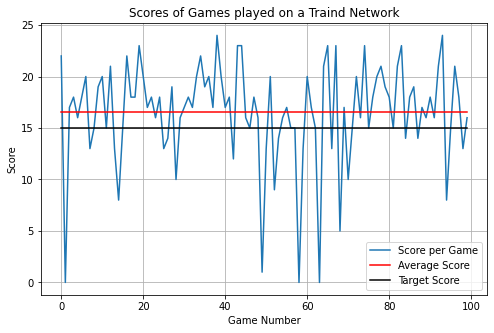

The trained network achieved an average of 1.53 reward points over the target score over 100 iterations.


In [24]:
#scores_trained = [dqn(train_mode=False,return_score=True) for i in range(100)]
plot_trained_score(scores_trained,save_plot=True,target_score=15)